# Step 4: Exploratory Data Analysis

## Imports

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#### Load Spacy's Default Things

In [17]:
nlp = spacy.load('en_core_web_sm')
stop_words_spacy = set(nlp.Defaults.stop_words)

## Read-In Data

In [18]:
health = pd.read_csv('../data/womens_health_preprocessed.csv', lineterminator='\n')
obsgyn = pd.read_csv('../data/fertility_and_pregnancy_preprocessed.csv')
pospar = pd.read_csv('../data/postpartum_preprocessed.csv')

## Check Head and Shape of Data

### General Women's Health Data

In [19]:
health.head(2)

,subreddit,author,timestamp,total_text,word_count,lemma_tokens,sentiment_score,negativity_score
0,WomensHealth,thecrazedbunny,2020-08-07,Been to the clinic twice and they don’t know w...,382,be clinic twice wrong . help ! so -PRON- probl...,0.7246,0.067
1,WomensHealth,Help-Me-Already,2020-08-07,Period going on for 14 days today. Help!! Hi g...,200,period 14 day today . help ! ! hi guy . -PRON-...,-0.5209,0.087


In [20]:
health.shape

(30616, 8)

### Fertility and Pregnancy Data

In [21]:
obsgyn.head(2)

,subreddit,author,timestamp,total_text,word_count,lemma_tokens,sentiment_score,negativity_score
0,TryingForABaby,lastput1,2020-08-07,Adding to the kitchen sink approach: I just bo...,81,add kitchen sink approach : -PRON- buy menstru...,0.8158,0.00
1,TryingForABaby,ParkingFrosting4,2020-08-07,Has anyone used/or currently an app to track t...,66,have / currently app track ovulation ? -PRON- ...,-0.2163,0.05


In [22]:
obsgyn.shape

(92943, 8)

### Postpartum Data

In [23]:
pospar.head(2)

,subreddit,author,timestamp,total_text,word_count,lemma_tokens,sentiment_score,negativity_score
0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...,43,question bottle -PRON- research baby bottle tr...,0.1779,0.05
1,BabyBumps,waterfallsummer,2020-08-07,Anyone else getting that generation gap judgem...,137,anyone get generation gap judgement ? aunt- -P...,0.8043,0.00


In [24]:
pospar.shape

(49094, 8)

### Reset Indices

In [25]:
health = health.reset_index(drop = True)
obsgyn = obsgyn.reset_index(drop = True)
pospar = pospar.reset_index(drop = True)

## Exploratory Data Analysis

#### Define Color Palette

In [26]:
blush = '#F7D1CD'
pink = '#E8C2CA'
light_purple = '#D1B3C4'
medium_purple = '#B392AC'
dark_purple = '#B392AC'
warm_grey = '#8E9AAF'

### How many unique authors are there per subject matter?

One of the reasons why we believe that using an online health forum to identify women's health concerns could be better than a focus group or targeted survey is because of the scope of people that we will be able to reach. Here, we will explore how many women voiced their concerns for each of the topics of interest.

If it appears that several users have authored multiple posts, I will also examine these posts to eliminate the chances of including advertisements or spam in my analyses.

In [27]:
def unique_authors(df, column, title):
    return f'{title} has {df[column].nunique()} unique authors.'

#### Women's Health

In [28]:
unique_authors(health, 'author', 'Women\'s Health')

"Women's Health has 19753 unique authors."

In terms of general women's health concerns, we have posts from 19,753 unique users. Because there are 31,385 total posts, this means that 11,361 posts were contributed by a duplicate user.

#### Fertility and Pregnancy

In [29]:
unique_authors(obsgyn, 'author', 'Fertility and Pregnancy')

'Fertility and Pregnancy has 35127 unique authors.'

The Fertility and Pregnancy data (`obsgyn`) has 98,138 total posts, but only 35,517 are unique. This means that 62,621 posts are by duplicate authors. 

#### Postpartum

In [30]:
unique_authors(pospar, 'author', 'Postpartum')

'Postpartum has 21585 unique authors.'

The postpartum data has posts that were authored by 21,821 unique users. Because there are 51,674 total posts in the data frame, this means that 29,853 posts are by duplicate authors. 

### Word Count Distributions

#### Define Stop Words

In [31]:
def add_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.add(word)

#### Create Full Stop Words List from NLTK, spaCy, and custom Stop Words

In [32]:
stop_words_spacy = set(nlp.Defaults.stop_words)
stop_words_nltk = set(stopwords.words('english'))

full_stop_words = stop_words_spacy.union(stop_words_nltk)

In [33]:
words_to_add = ['like', 'know', 'want', 'feel', 'going', 'think', 'reddit', 'imgur', 'pron', 'officially']

add_stop_words(words_to_add, full_stop_words)

#### Visualize Word Count Distributions

In [38]:
def subplot_histogram(data, axis, title = None, x_label = None, y_label = None, color = None):
    sns.distplot(data, ax = axis, kde = False, hist_kws=dict(edgecolor="k", linewidth=.9, alpha = 0.9), color = color)
    axis.set_title(title, pad = 8, fontdict = {'fontsize':14})
    axis.set_xlabel(x_label, labelpad = 6, fontdict = {'fontsize':13})
    axis.set_ylabel(y_label, labelpad = 6, fontdict = {'fontsize':13})
    axis.tick_params(axis = 'both', labelsize = 11)
    plt.tight_layout();

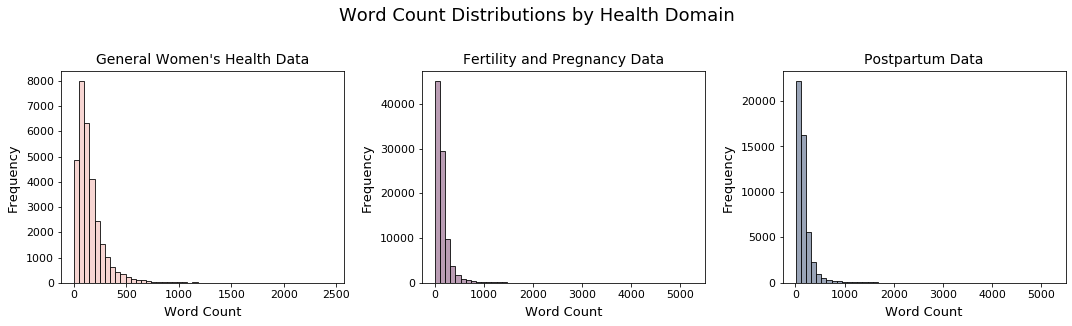

In [39]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4))

ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

subplot_histogram(health['word_count'], 
                  axis = ax1,
                  title = 'General Women\'s Health Data',
                  x_label = 'Word Count',
                  y_label = 'Frequency',
                  color = blush )


subplot_histogram(obsgyn['word_count'], 
                  axis = ax2,
                  title = 'Fertility and Pregnancy Data',
                  x_label = 'Word Count',
                  y_label = 'Frequency',
                  color = dark_purple)

subplot_histogram(pospar['word_count'],
                  axis = ax3,
                  title = 'Postpartum Data',
                  x_label = 'Word Count',
                  y_label = 'Frequency',
                  color = warm_grey)

plt.suptitle('Word Count Distributions by Health Domain', y = 1.12, size = 18);

As shown in the histograms above, the majority of posts for all three health domains are less than 1000 words in length.

**General Women's Health Domain**: The average word count for the Women's Health domain was 154.5, but word counts ranged from 1 to 2453 words. Almost 75% of posts had word counts of 193 words or less. 

**Fertility and Pregnancy Domain**: The average word count for the Fertility and Pregnancy domain was 154.2 words, but word counts varied from 1 to 5238 words. Almost 75% of posts had word counts of 182 words or less.

**Postpartum Domain**: The average word count for the Postpartum domain is 169.8 words, but word counts range from 1 to 5238. Almost 75% of posts have word counts of 195 words or less.

### Visualizing Most Common Words and Bigrams

#### Functions

In [40]:
def get_word_vector(data, ngrams = (1,1), stopwords = None, min_df = 0.005):
    cvec = CountVectorizer(stop_words = stopwords, ngram_range = ngrams, min_df = min_df)
    words = cvec.fit_transform(data)
    df = pd.DataFrame(words.toarray(), columns = cvec.get_feature_names())
    return df

In [41]:
def get_word_sums(words_df):
    word_sum = {}
    for column in words_df.columns:
        word_sum[column] = words_df[column].sum()
    df = pd.DataFrame(sorted(word_sum.items(), key = lambda x: x[1], reverse = True), columns = ['Word', 'Count'])
    return df.sort_values('Count', ascending = False)

In [42]:
def plot_top_words(word_count_df, title = None, x_label = None, y_label = None, color = None, size = (18,10)):
    plt.figure(figsize = size)
    sns.barplot(x = word_count_df['Word'][:10], y = word_count_df['Count'][:10], color = color, edgecolor = 'black')
    plt.title(title, fontdict = {'fontsize':15}, pad = 12)
    plt.xlabel('Word', fontdict = {'fontsize':13}, labelpad = 10)
    plt.ylabel('Count', fontdict = {'fontsize':13}, labelpad = 10)
    plt.tight_layout;

#### Define Corpus

In [43]:
og_health_corpus = health['total_text'].copy()
og_obsgyn_corpus = obsgyn['total_text'].copy()
og_pospar_corpus = pospar['total_text'].copy()

### Most Frequent Words - Stop Words ***NOT*** Removed

In [44]:
# Create Bag of Words

og_health_words = get_word_vector(og_health_corpus)
og_obsgyn_words = get_word_vector(og_obsgyn_corpus)
og_pospar_words = get_word_vector(og_pospar_corpus)

In [45]:
# Count the Number of Times that Each Word Appears

og_health_word_counts = get_word_sums(og_health_words)
og_obsgyn_word_counts = get_word_sums(og_obsgyn_words)
og_pospar_word_counts = get_word_sums(og_pospar_words)

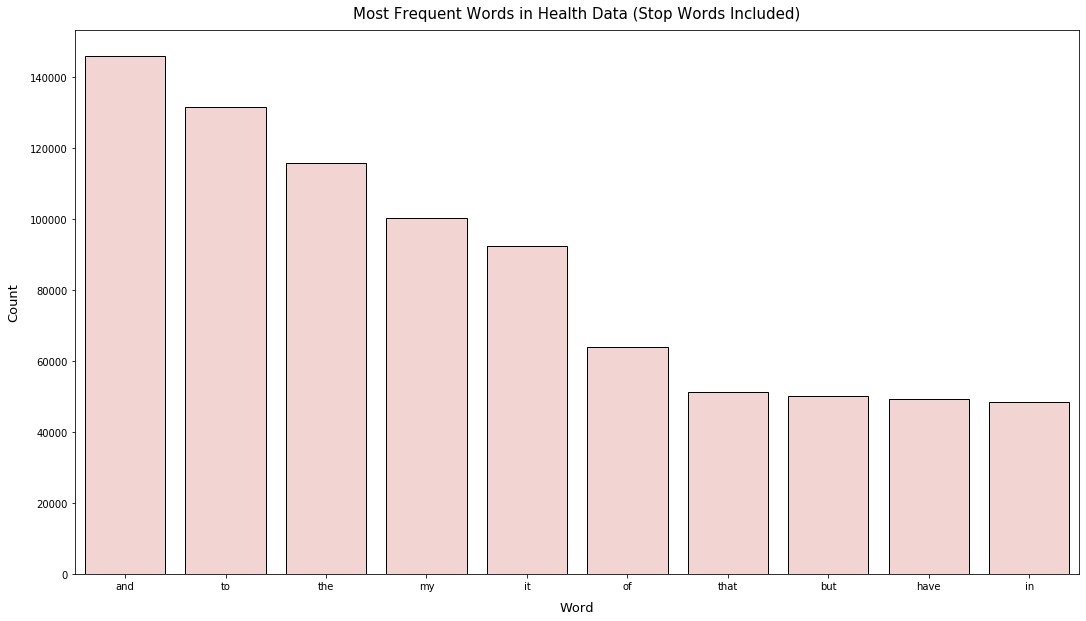

In [46]:
# Plot Top 10 Word Counts
plot_top_words(og_health_word_counts, 
               title = 'Most Frequent Words in Health Data (Stop Words Included)',
               color = blush)

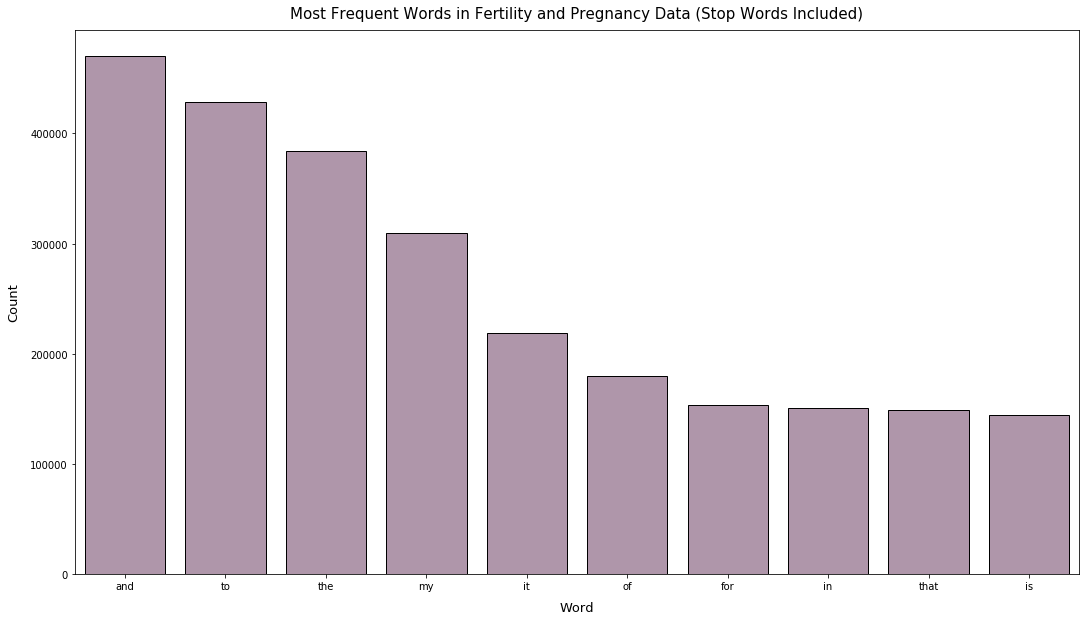

In [47]:
plot_top_words(og_obsgyn_word_counts, 
               title = 'Most Frequent Words in Fertility and Pregnancy Data (Stop Words Included)',
               color = dark_purple)

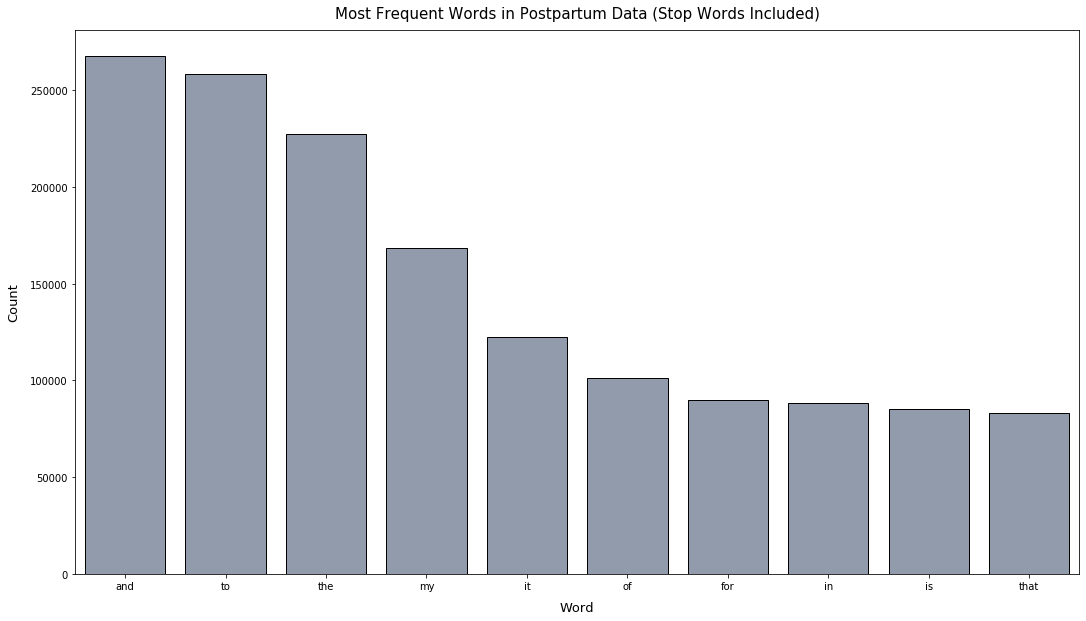

In [48]:
plot_top_words(og_pospar_word_counts, 
               title = 'Most Frequent Words in Postpartum Data (Stop Words Included)',
               color = warm_grey)

### Most Frequent Words by Data Set - Stopwords Removed

In [52]:
swr_health_words = get_word_vector(og_health_corpus, stopwords = full_stop_words)
swr_obsgyn_words = get_word_vector(og_obsgyn_corpus, stopwords = full_stop_words)
swr_pospar_words = get_word_vector(og_pospar_corpus, stopwords = full_stop_words)

In [53]:
swr_health_word_counts = get_word_sums(swr_health_words)
swr_obsgyn_word_counts = get_word_sums(swr_obsgyn_words)
swr_pospar_word_counts = get_word_sums(swr_pospar_words)

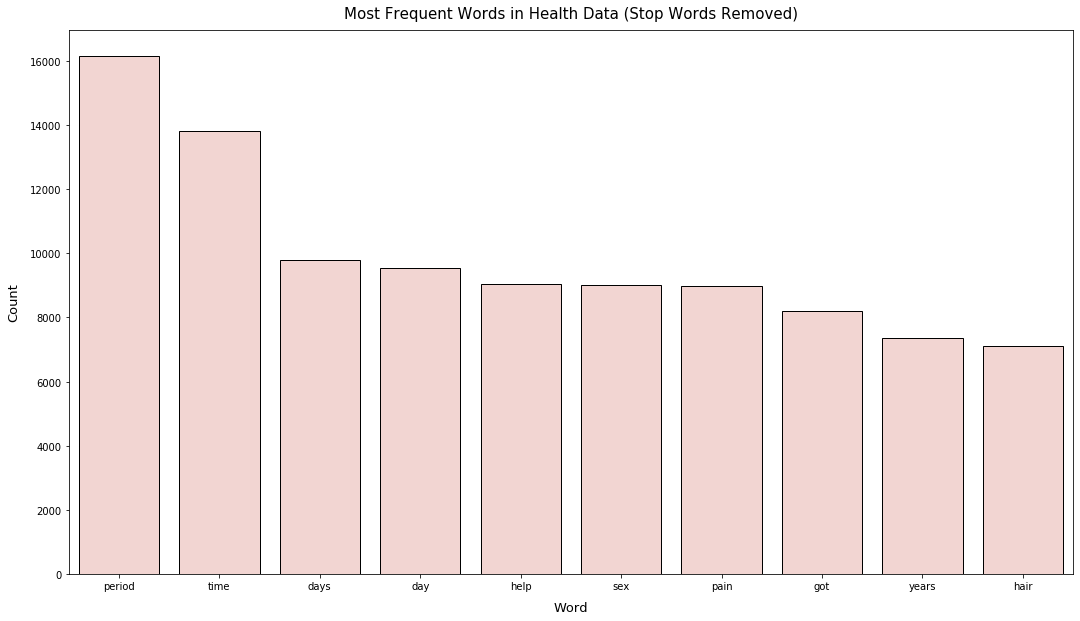

In [54]:
plot_top_words(swr_health_word_counts, 
               title = 'Most Frequent Words in Health Data (Stop Words Removed)',
               color = blush)

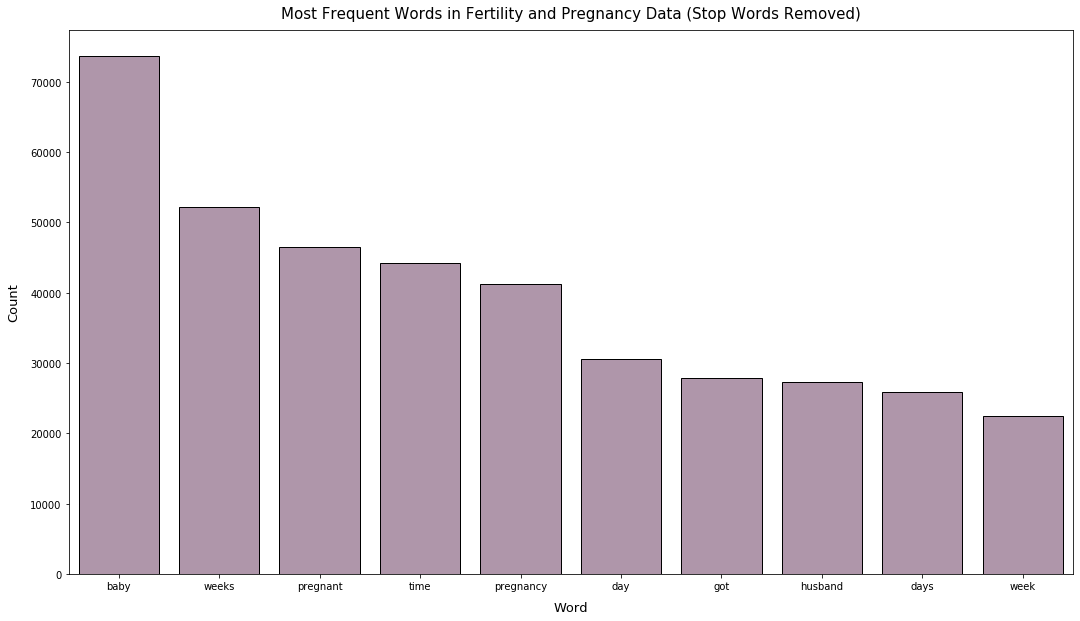

In [55]:
plot_top_words(swr_obsgyn_word_counts, 
               title = 'Most Frequent Words in Fertility and Pregnancy Data (Stop Words Removed)',
               color = dark_purple)

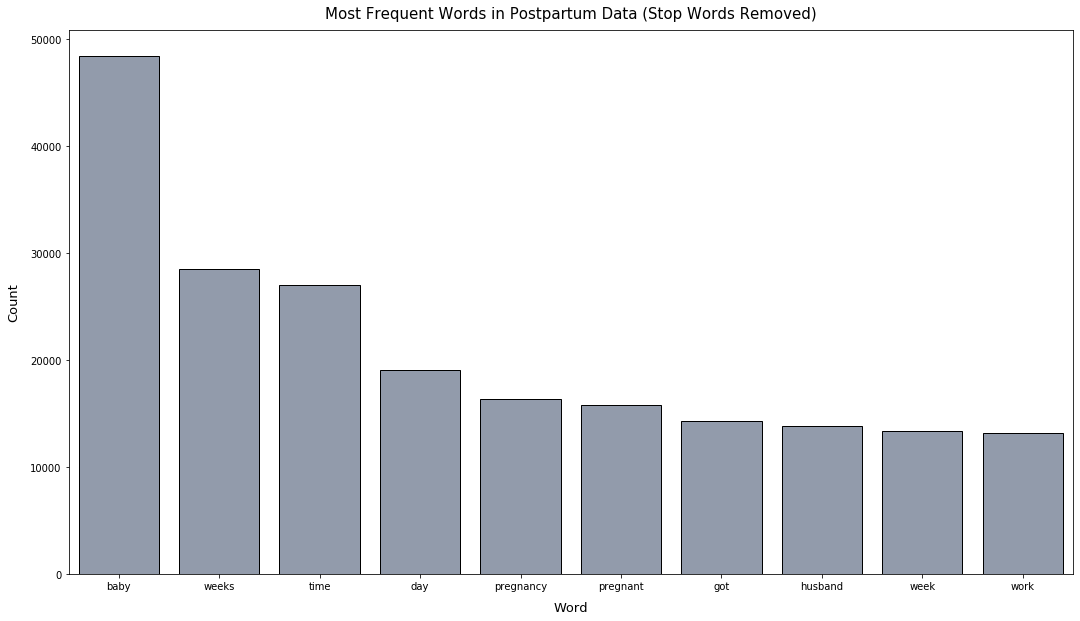

In [56]:
plot_top_words(swr_pospar_word_counts, 
               title = 'Most Frequent Words in Postpartum Data (Stop Words Removed)',
               color = warm_grey)

### Most Frequent Bigrams by Data Set - Stopwords Removed

In [57]:
swr_health_bigrams = get_word_vector(og_health_corpus, ngrams = (2,2), stopwords = full_stop_words)
swr_obsgyn_bigrams = get_word_vector(og_obsgyn_corpus, ngrams = (2,2), stopwords = full_stop_words)
swr_pospar_bigrams = get_word_vector(og_pospar_corpus, ngrams = (2,2), stopwords = full_stop_words)

In [58]:
swr_health_bigrams_counts = get_word_sums(swr_health_bigrams)
swr_obsgyn_bigrams_counts = get_word_sums(swr_obsgyn_bigrams)
swr_pospar_bigrams_counts = get_word_sums(swr_pospar_bigrams)

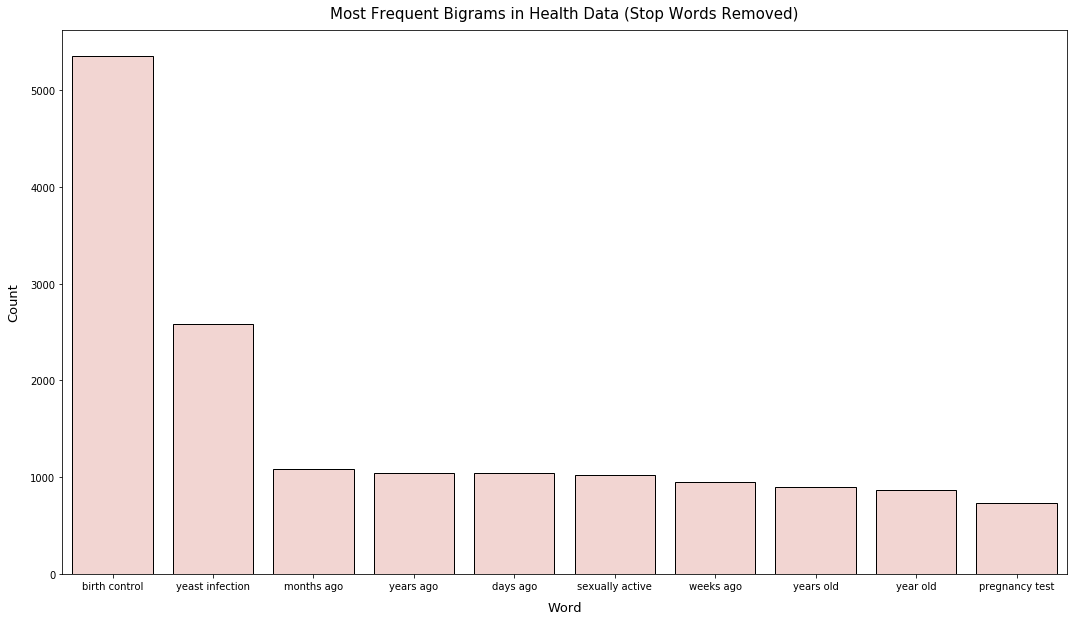

In [59]:
plot_top_words(swr_health_bigrams_counts, 
               title = 'Most Frequent Bigrams in Health Data (Stop Words Removed)',
               color = blush)

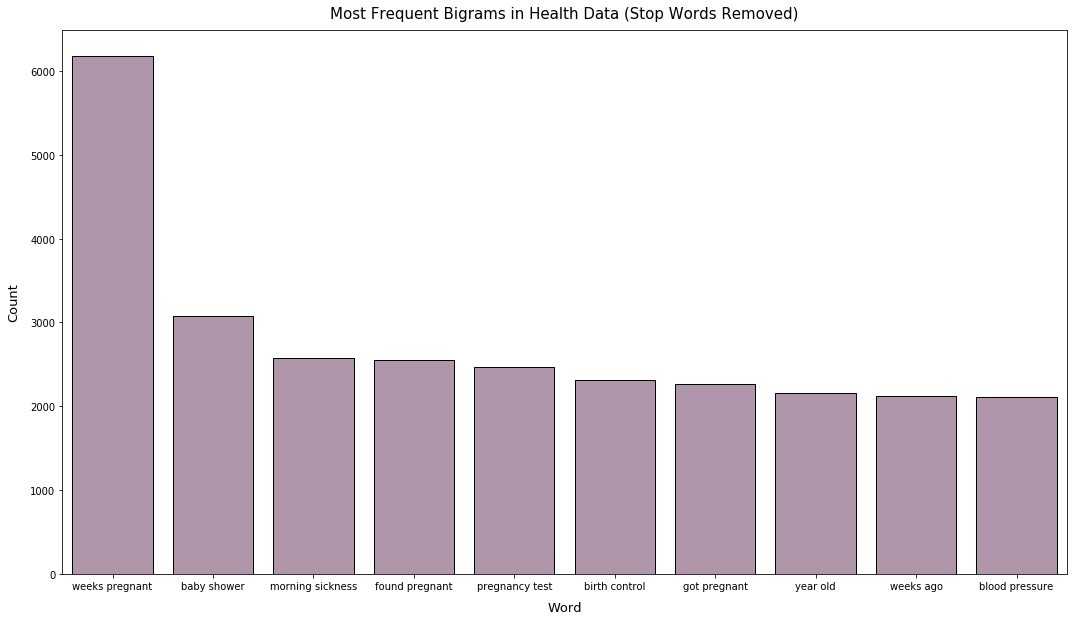

In [61]:
plot_top_words(swr_obsgyn_bigrams_counts, 
               title = 'Most Frequent Bigrams in Health Data (Stop Words Removed)',
               color = dark_purple)

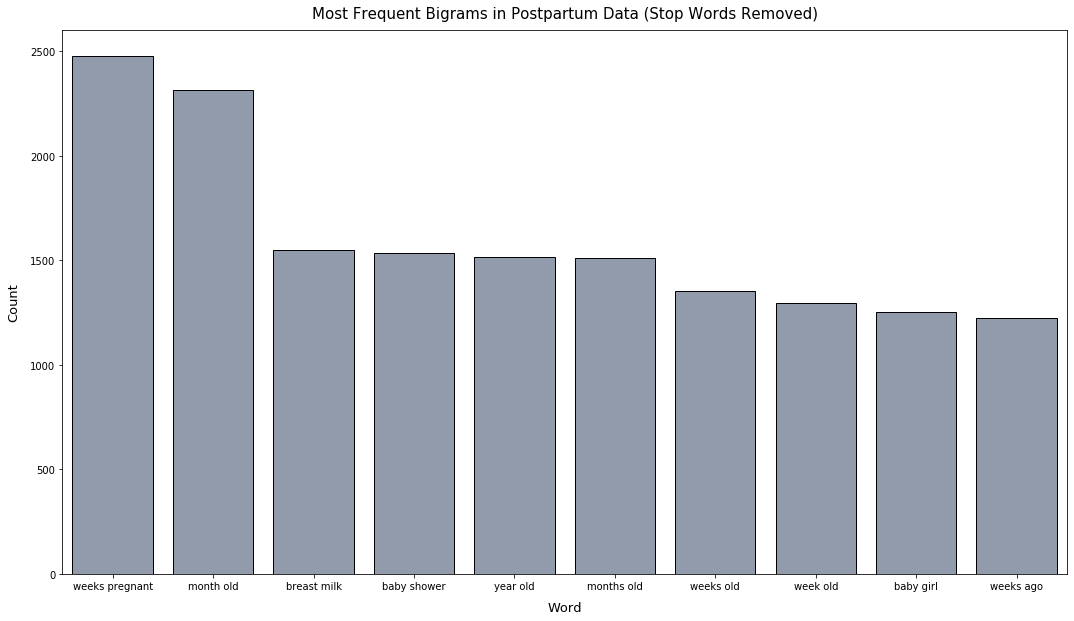

In [62]:
plot_top_words(swr_pospar_bigrams_counts, 
               title = 'Most Frequent Bigrams in Postpartum Data (Stop Words Removed)',
               color = warm_grey)

### Most Frequent Trigrams - Stop Words Removed

In [94]:
swr_health_trigrams = get_word_vector(og_health_corpus, ngrams = (3,3), stopwords = full_stop_words, min_df = 0.005)
swr_obsgyn_trigrams = get_word_vector(og_obsgyn_corpus, ngrams = (3,3), stopwords = full_stop_words, min_df = 0.003)
swr_pospar_trigrams = get_word_vector(og_pospar_corpus, ngrams = (3,3), stopwords = full_stop_words, min_df = 0.003)

In [95]:
swr_health_trigrams_counts = get_word_sums(swr_health_trigrams)
swr_obsgyn_trigrams_counts = get_word_sums(swr_obsgyn_trigrams)
swr_pospar_trigrams_counts = get_word_sums(swr_pospar_trigrams)

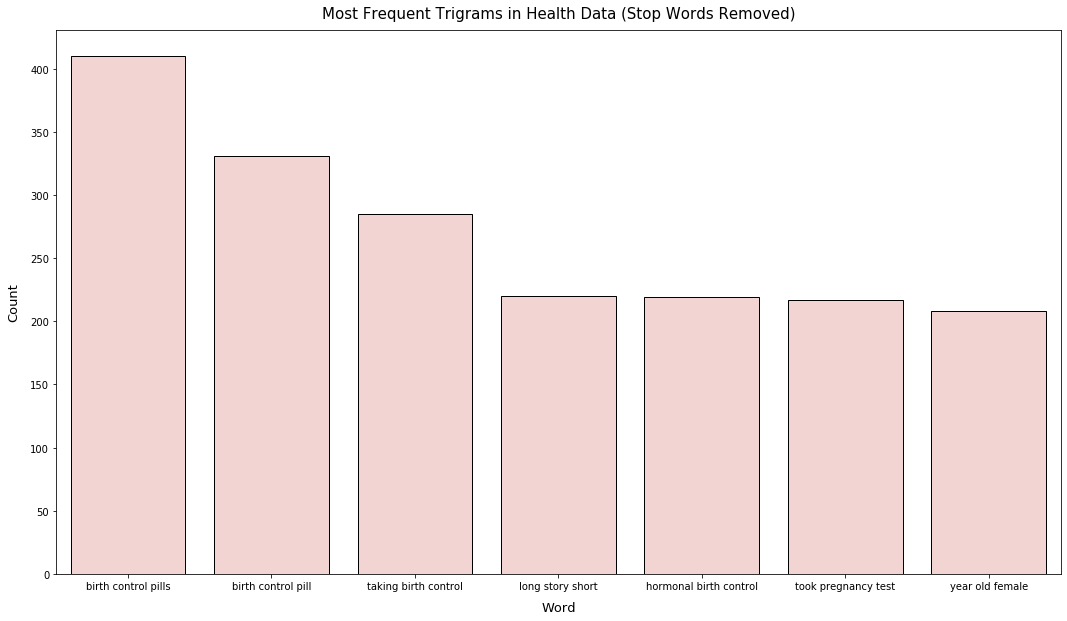

In [96]:
plot_top_words(swr_health_trigrams_counts, 
               title = 'Most Frequent Trigrams in Health Data (Stop Words Removed)',
               color = blush)

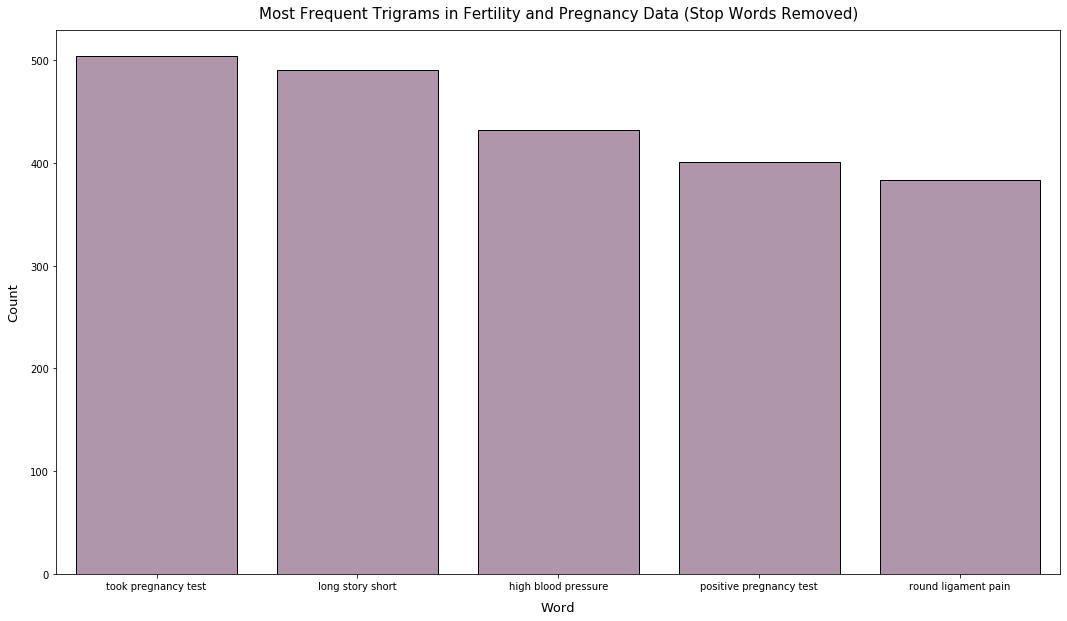

In [97]:
plot_top_words(swr_obsgyn_trigrams_counts, 
               title = 'Most Frequent Trigrams in Fertility and Pregnancy Data (Stop Words Removed)',
               color = dark_purple,
               size = (18, 10))

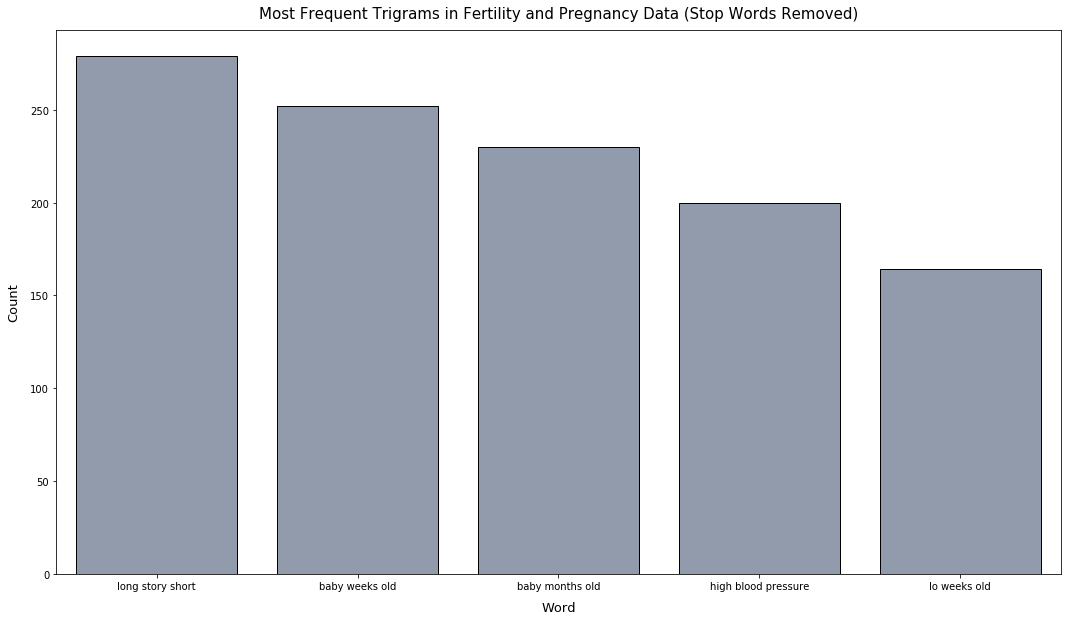

In [98]:
plot_top_words(swr_pospar_trigrams_counts, 
               title = 'Most Frequent Trigrams in Fertility and Pregnancy Data (Stop Words Removed)',
               color = warm_grey,
               size = (18, 10))

### Define Lemmatized Corpus

In [68]:
lemmas_health_corpus = health['lemma_tokens']
lemmas_obsgyn_corpus = obsgyn['lemma_tokens']
lemmas_pospar_corpus = pospar['lemma_tokens']

#### Single Words

In [69]:
lemmas_health_words = get_word_vector(lemmas_health_corpus, stopwords = full_stop_words)
lemmas_obsgyn_words = get_word_vector(lemmas_obsgyn_corpus, stopwords = full_stop_words)
lemmas_pospar_words = get_word_vector(lemmas_pospar_corpus, stopwords = full_stop_words)

lemmas_health_word_counts = get_word_sums(lemmas_health_words)
lemmas_obsgyn_word_counts = get_word_sums(lemmas_obsgyn_words)
lemmas_pospar_word_counts = get_word_sums(lemmas_pospar_words)

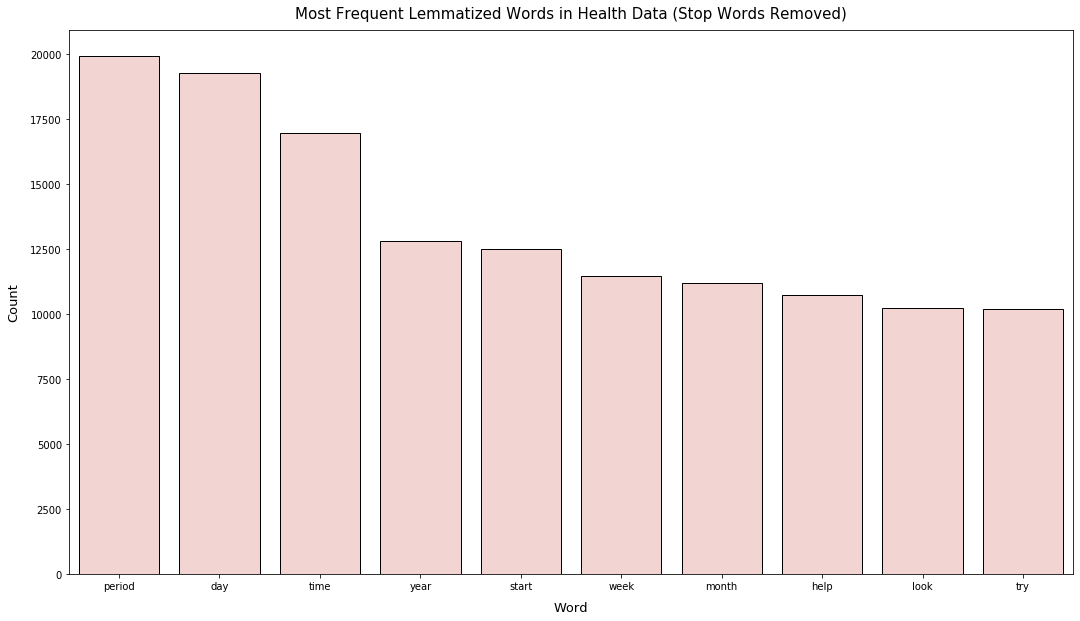

In [70]:
plot_top_words(lemmas_health_word_counts, 
               title = 'Most Frequent Lemmatized Words in Health Data (Stop Words Removed)',
               color = blush)

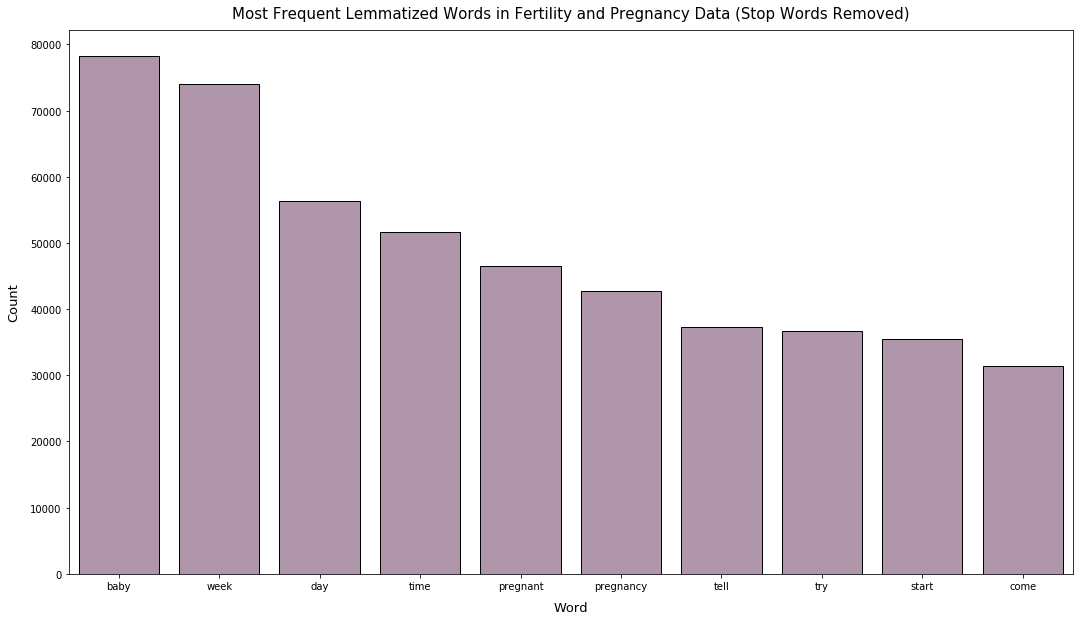

In [71]:
plot_top_words(lemmas_obsgyn_word_counts, 
               title = 'Most Frequent Lemmatized Words in Fertility and Pregnancy Data (Stop Words Removed)',
               color = dark_purple)

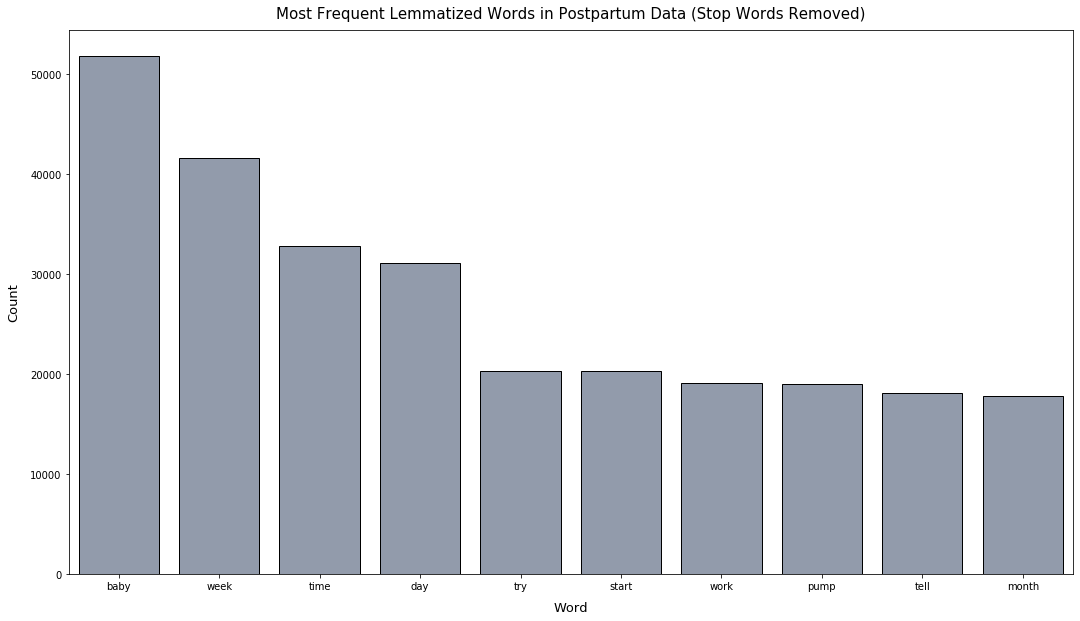

In [72]:
plot_top_words(lemmas_pospar_word_counts, 
               title = 'Most Frequent Lemmatized Words in Postpartum Data (Stop Words Removed)',
               color = warm_grey)

#### Bigrams

In [73]:
lemmas_health_bigrams = get_word_vector(lemmas_health_corpus, ngrams = (2,2), stopwords = full_stop_words)
lemmas_obsgyn_bigrams = get_word_vector(lemmas_obsgyn_corpus, ngrams = (2,2), stopwords = full_stop_words)
lemmas_pospar_bigrams = get_word_vector(lemmas_pospar_corpus, ngrams = (2,2), stopwords = full_stop_words)

lemmas_health_bigrams_counts = get_word_sums(lemmas_health_bigrams)
lemmas_obsgyn_bigrams_counts = get_word_sums(lemmas_obsgyn_bigrams)
lemmas_pospar_bigrams_counts = get_word_sums(lemmas_pospar_bigrams)

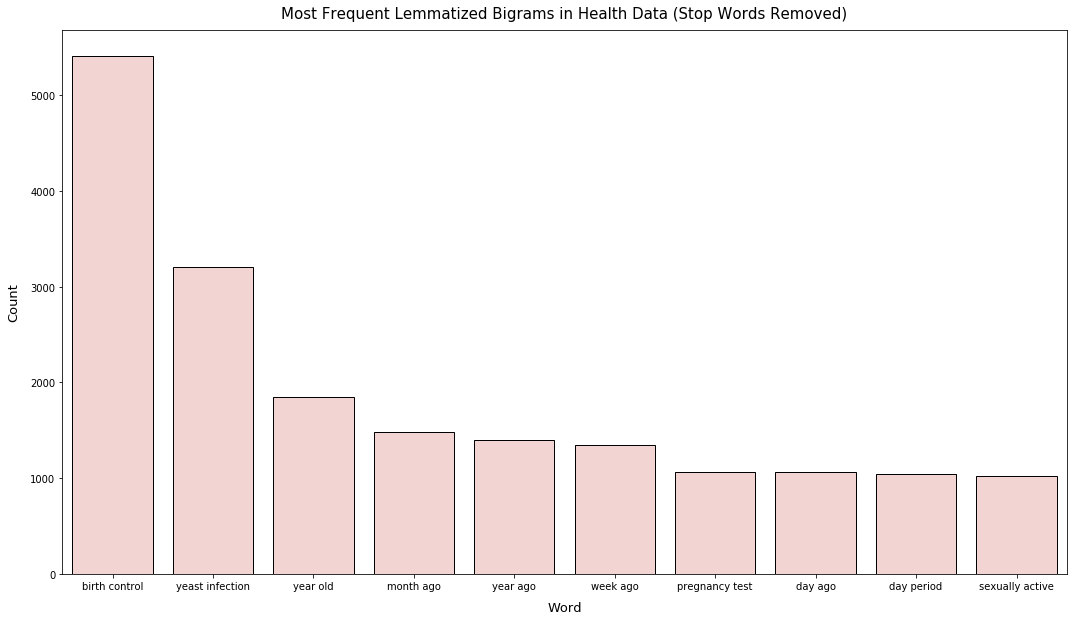

In [74]:
plot_top_words(lemmas_health_bigrams_counts, 
               title = 'Most Frequent Lemmatized Bigrams in Health Data (Stop Words Removed)',
               color = blush)

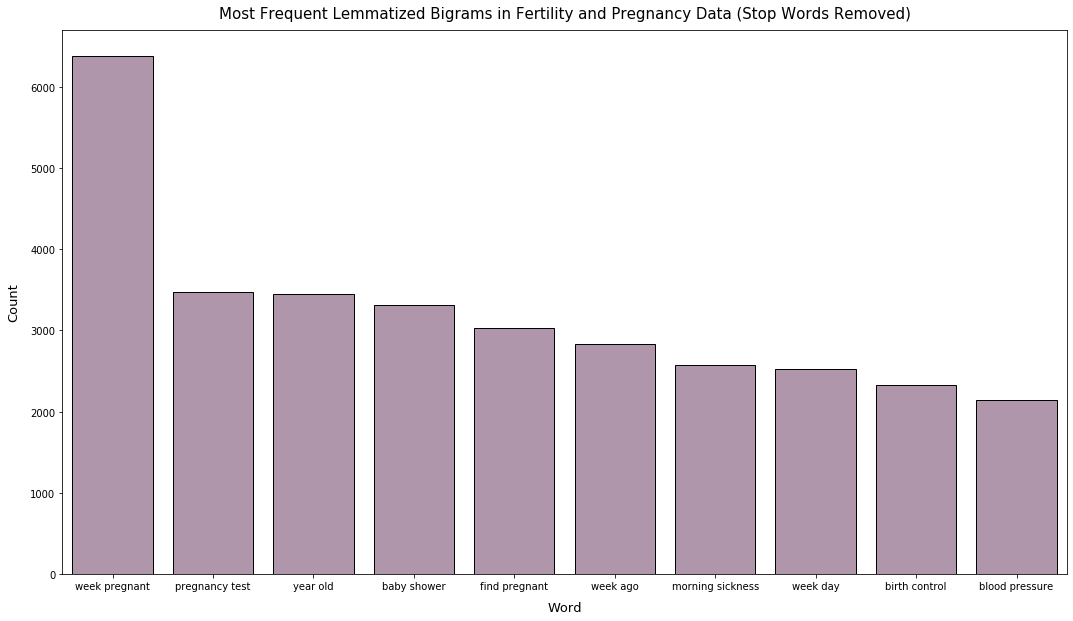

In [75]:
plot_top_words(lemmas_obsgyn_bigrams_counts, 
               title = 'Most Frequent Lemmatized Bigrams in Fertility and Pregnancy Data (Stop Words Removed)',
               color = dark_purple)

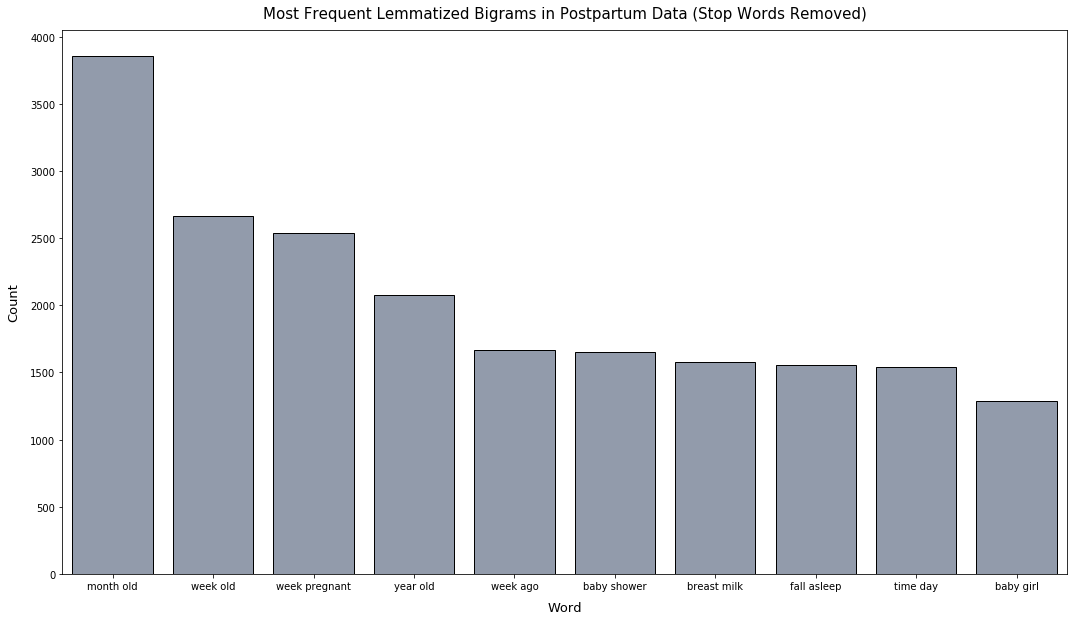

In [76]:
plot_top_words(lemmas_pospar_bigrams_counts, 
               title = 'Most Frequent Lemmatized Bigrams in Postpartum Data (Stop Words Removed)',
               color = warm_grey)

#### Trigrams

In [86]:
lemmas_health_trigrams = get_word_vector(lemmas_health_corpus, ngrams = (3,3), stopwords = full_stop_words)
lemmas_obsgyn_trigrams = get_word_vector(lemmas_obsgyn_corpus, ngrams = (3,3), stopwords = full_stop_words, min_df = 0.003)
lemmas_pospar_trigrams = get_word_vector(lemmas_pospar_corpus, ngrams = (3,3), stopwords = full_stop_words, min_df = 0.003)

lemmas_health_trigrams_counts = get_word_sums(lemmas_health_trigrams)
lemmas_obsgyn_trigrams_counts = get_word_sums(lemmas_obsgyn_trigrams)
lemmas_pospar_trigrams_counts = get_word_sums(lemmas_pospar_trigrams)

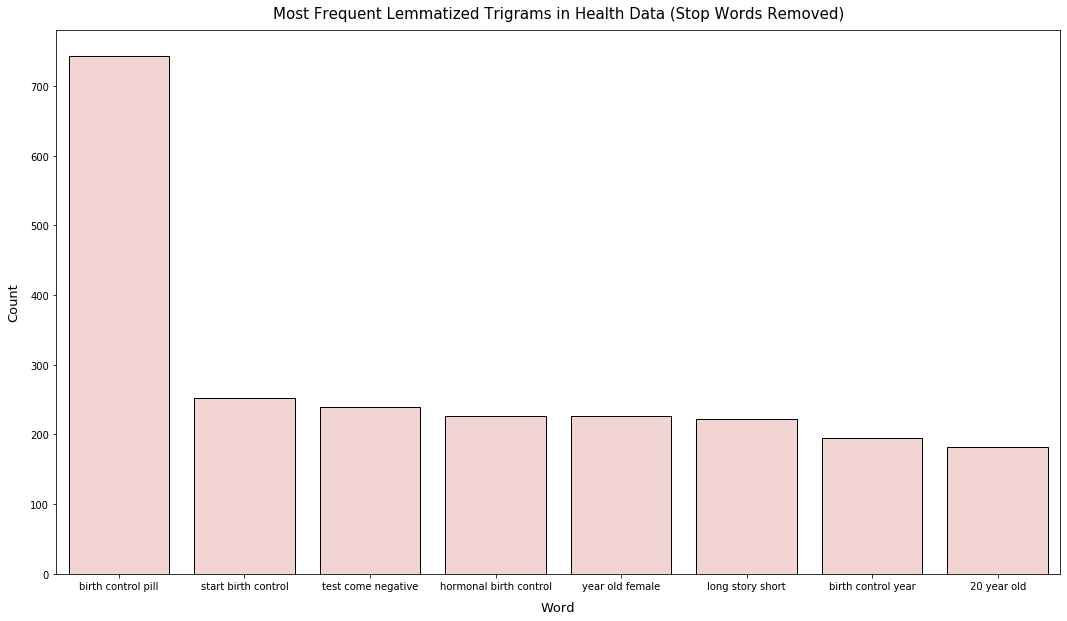

In [87]:
plot_top_words(lemmas_health_trigrams_counts, 
               title = 'Most Frequent Lemmatized Trigrams in Health Data (Stop Words Removed)',
               color = blush)

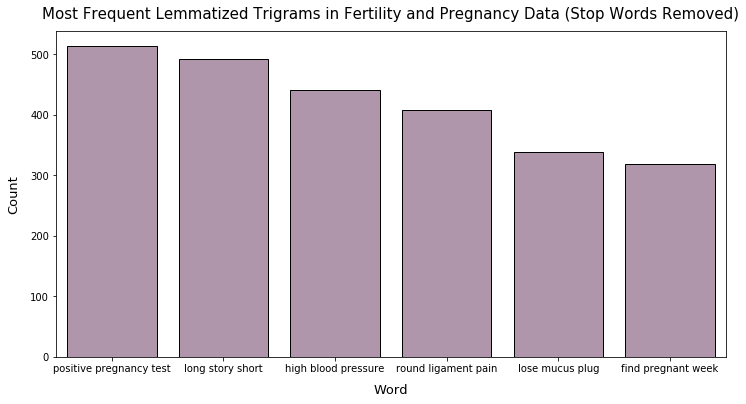

In [100]:
plot_top_words(lemmas_obsgyn_trigrams_counts, 
               title = 'Most Frequent Lemmatized Trigrams in Fertility and Pregnancy Data (Stop Words Removed)',
               color = dark_purple,
               size = (12, 6))

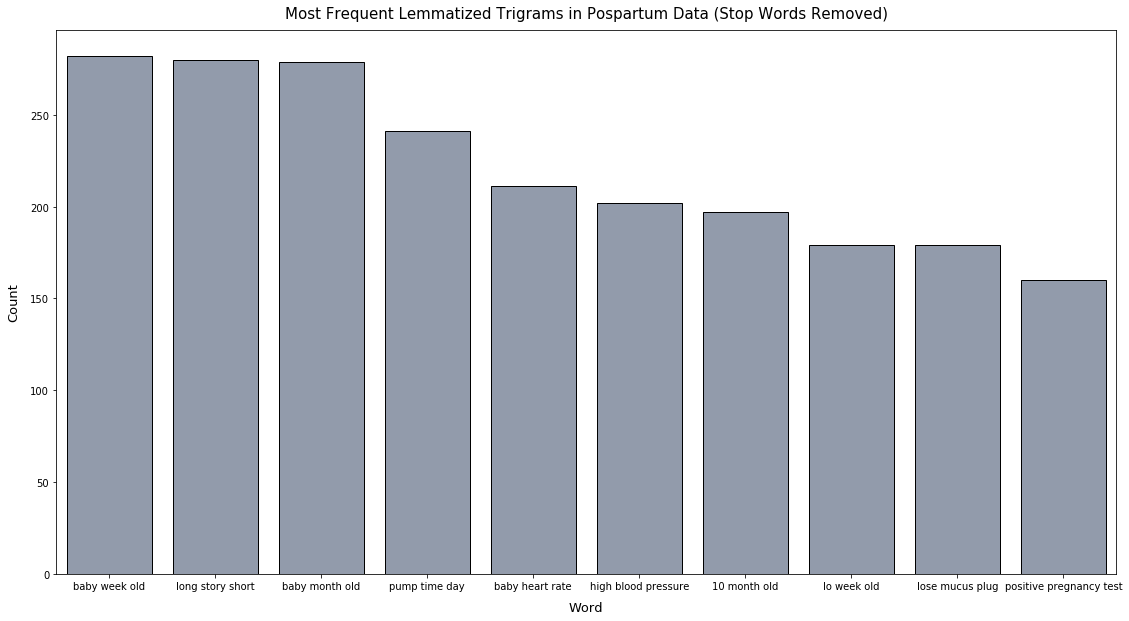

In [90]:
plot_top_words(lemmas_pospar_trigrams_counts, 
               title = 'Most Frequent Lemmatized Trigrams in Pospartum Data (Stop Words Removed)',
               color = warm_grey,
               size = (19, 10))

### Sentiment Analysis

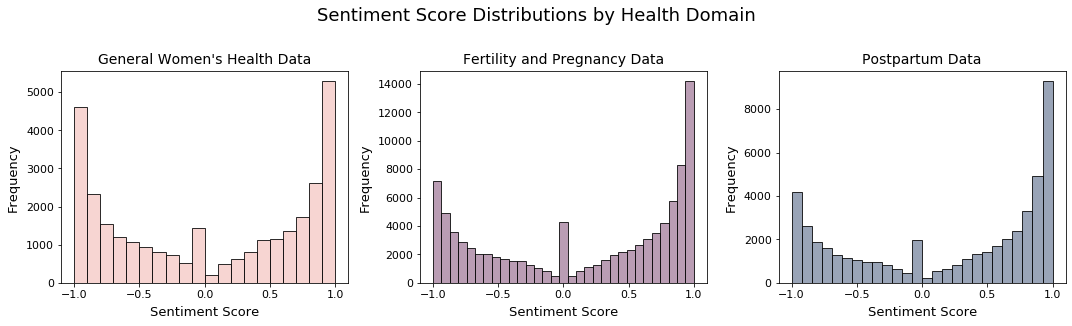

In [91]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4))

ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

subplot_histogram(health['sentiment_score'], 
                  axis = ax1,
                  title = 'General Women\'s Health Data',
                  x_label = 'Sentiment Score',
                  y_label = 'Frequency',
                  color = blush )


subplot_histogram(obsgyn['sentiment_score'], 
                  axis = ax2,
                  title = 'Fertility and Pregnancy Data',
                  x_label = 'Sentiment Score',
                  y_label = 'Frequency',
                  color = dark_purple)

subplot_histogram(pospar['sentiment_score'],
                  axis = ax3,
                  title = 'Postpartum Data',
                  x_label = 'Sentiment Score',
                  y_label = 'Frequency',
                  color = warm_grey)

plt.suptitle('Sentiment Score Distributions by Health Domain', y = 1.12, size = 18);